## Prediction

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from src.data.load_data import load_sample_data

In [12]:
n_jobs = -1  # pour le parallélisme
letters = [chr(i) for i in range(ord("a"), ord("z") + 1)]

In [13]:
# from src.constants import data_folder, img_shape
from src.utils.misc import init_notebook

In [14]:
init_notebook()

In [15]:
df = load_sample_data()

## Stratégie d'évaluation

On se propose d'utiliser une StratifiedKFold : 
- on utilise la cross-validation (plus fiable que le train/test split)
- on utilise la stratégie KFold (plusieurs passes sur le jeu de données donc une estimation plus fiable)
- on mélange aléatoirement les données ("shuffle") pour éviter un éventuel tri des données initiales (ce qui induirait un fort biais, les données $i$ et $i+1$ pourraient être corrélées si elles étaient triées, et chaque fold pourrait n'être confronté qu'à une seule classe au lieu des 10 dans le pire des cas)
- c'est une méthode très adaptée à un jeu de données avec plusieurs classes : en effet, la version stratifiée permet de respecter la répartition des classes, ce qui est d'autant plus utile que les classes sont déséquilibrées. Ici les classes sont équilibrées donc l'avantage est moindre mais la version stratifiée est théoriquement meilleure.

In [16]:
from sklearn.model_selection import StratifiedKFold, train_test_split

In [17]:
def strategie_evaluation(seed: int = 0, n_splits: int = 5):
    """Crée notre stratégie d'évaluation"""
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    return kfold

In [18]:
kfold = strategie_evaluation(n_splits=10)

### Métrique

Nous proposons d'utiliser l'accuracy.

In [39]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
)

### Création du x et du y

In [40]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.2
)

In [22]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [23]:
# vérifions les shapes
print(f"{X_train.shape = }")
print(f"{y_train.shape = }")
print(f"{X_test.shape = }")
print(f"{y_test.shape = }")

X_train.shape = (2400, 784)
y_train.shape = (2400,)
X_test.shape = (600, 784)
y_test.shape = (600,)


In [24]:
from time import time

#### Evaluation des modèles

In [44]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Affiche l'accuracy et la matrice de confusion du modèle"""
    debut = time()

    model.fit(X_train, y_train)

    fin = time()
    print(f"temps de calcul {round(fin - debut, 2)} s")

    y_pred = model.predict(X_test)

    score = accuracy_score(y_test, y_pred)
    print(f"accuracy = {score}")
    score = f1_score(y_test, y_pred, average=None)
    print(f"f1_score = {score}")
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=letters)

    fig, ax = plt.subplots(figsize=(14, 10))
    disp.plot(ax=ax)
    plt.show()

## 1ers modèles (hyper-paramètres par défaut)

Nous allons tester 2 modèles :
- Extra Trees (non vu en cours)
- Random Forest (vu en cours)

Puis nous allons optimiser les hyper-paramètres sur le Random Forest

### Extra Trees (ET)

In [45]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_jobs=n_jobs)

temps de calcul 0.2 s
accuracy = 0.8266666666666667
f1_score = [0.75409836 0.88888889 0.92307692 0.4        0.88235294 1.
 0.52173913 0.60869565 0.         0.7826087  0.58823529 0.84210526
 0.88       0.71232877 0.90566038 0.9375     0.4        0.89655172
 0.90123457 0.89285714 0.80808081 0.73684211 0.47058824 0.8
 0.66666667]


ValueError: The number of FixedLocator locations (25), usually from a call to set_ticks, does not match the number of labels (26).

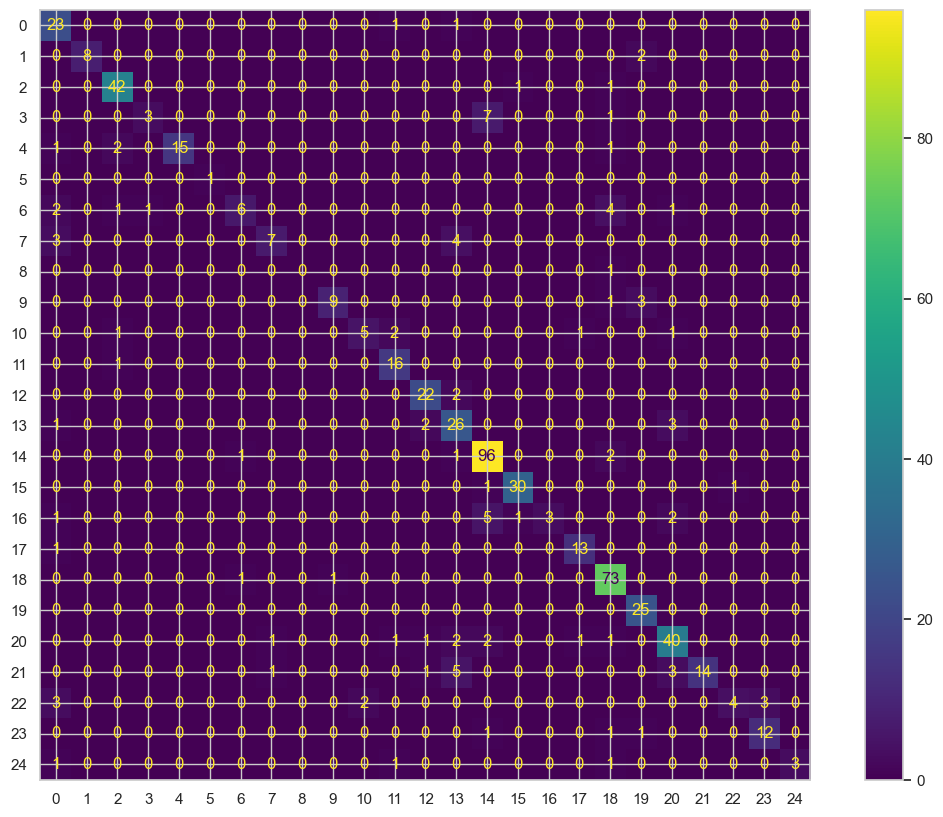

In [46]:
evaluate_model(et, X_train, y_train, X_test, y_test)

### Random Forest

In [47]:
rf_defaut = RandomForestClassifier(random_state=0, n_jobs=n_jobs)

temps de calcul 0.28 s
accuracy = 0.8266666666666667
f1_score = [0.76666667 0.88888889 0.89130435 0.44444444 0.8        0.
 0.54545455 0.57142857 0.         0.66666667 0.58823529 0.86486486
 0.91304348 0.77142857 0.90140845 0.90909091 0.4        0.89655172
 0.8902439  0.94339623 0.83168317 0.82926829 0.52631579 0.75862069
 0.5       ]


ValueError: The number of FixedLocator locations (25), usually from a call to set_ticks, does not match the number of labels (26).

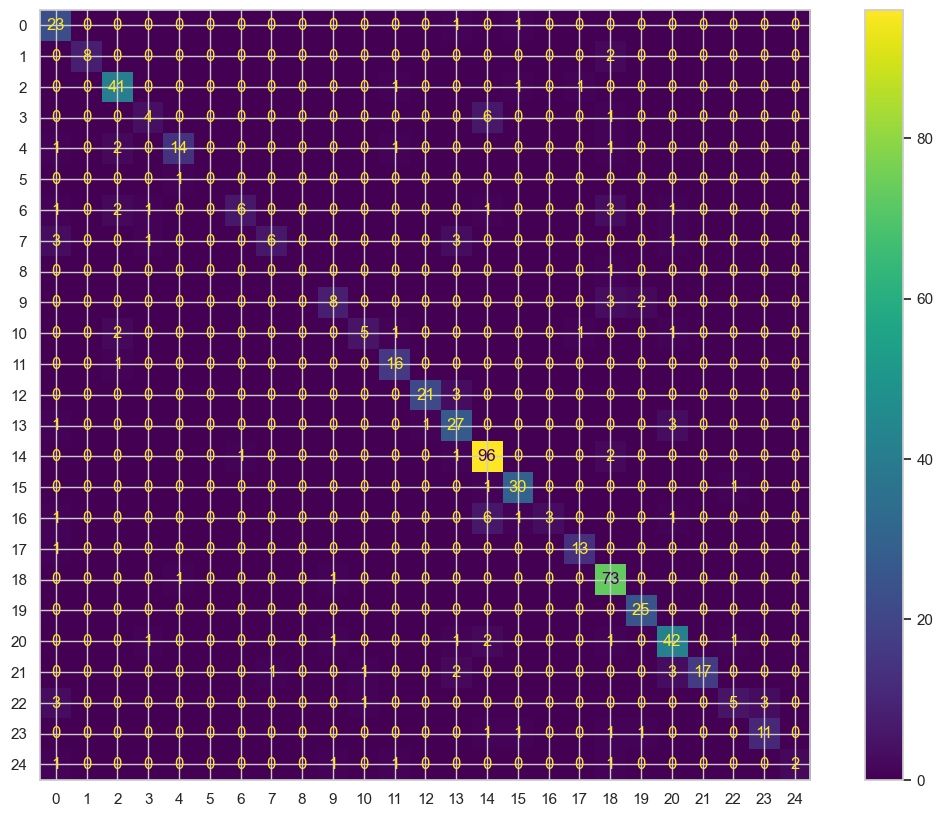

In [48]:
evaluate_model(rf_defaut, X_train, y_train, X_test, y_test)

## Grid search sur Hyper paramètres

Nous effectuons une grid search avec cross-validation Stratified K Fold

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
rf_tuning = RandomForestClassifier(random_state=0, n_jobs=n_jobs)

In [33]:
from sklearn.metrics import make_scorer

model_params = {
    "max_depth": [None, 5, 10],
    "n_estimators": [100, 50],
}

clf = GridSearchCV(
    estimator=rf_tuning,
    param_grid=model_params,
    scoring=make_scorer(accuracy_score),
    n_jobs=n_jobs,
    verbose=1,
    cv=kfold,
)

clf.fit(
    X_train, y_train
)  # décommenter pour exécuter (peut durer des dizaines de minutes)
results = pd.DataFrame(clf.cv_results_)  # résultats détaillés de la CV
clf.best_estimator_  # notre meilleur modèle de RandomForest qu'on a obtenu

Fitting 10 folds for each of 6 candidates, totalling 60 fits


C:\Users\AB2-PC\Documents\GitHub\ab2\recognize-handwritten-letters\.venv\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


RandomForestClassifier(n_jobs=-1, random_state=0)

In [34]:
print("Voici les meilleurs paramètres")
print(f"{clf.best_estimator_.max_depth = },\n{clf.best_estimator_.n_estimators = }")

Voici les meilleurs paramètres
clf.best_estimator_.max_depth = None,
clf.best_estimator_.n_estimators = 100


Le meilleur modèle est le même que celui par défaut.